In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
from sklearn import datasets, linear_model
from sklearn import model_selection
import time
from math import sqrt
from math import floor
from sklearn.cluster import DBSCAN
from statistics import mean 
import warnings
warnings.filterwarnings('ignore')

# Q1.

In [2]:
def myridge(y,x,k,l): 
    beta=linalg.solve(x.transpose()@x+l*np.identity(k),x.transpose()@y)
    return beta

load data

In [3]:
names = ['userID', 'itemID', 'rating','']
for i in range(1,6):
    url = "./ml-100k/u"+str(i)+".base"
    globals()['train%s' %i] = pd.read_csv(url, names=names, sep='\t', usecols = [0,1,2], header=None)
    url = "./ml-100k/u"+str(i)+".test"
    globals()['test%s' %i] = pd.read_csv(url, names=names, sep='\t', usecols = [0,1,2], header=None)

In [4]:
def conv(x):
    try:
        x = int(x)
    except ValueError:
        x = 51064
    return x

In [5]:
names = ['userID', 'age', 'gender','occupation','zip']
url = "./ml-100k/u.user"
user = pd.read_csv(url, sep='|', names=names, header=None, converters = {'zip':conv})

In [6]:
url = "./ml-100k/u.item"
mylist = list(range(24))
mylist.remove(1)
mylist.remove(3)
mylist.remove(4)
item = pd.read_csv(url, sep='|', header=None, usecols = mylist, encoding = "ISO-8859-1")

In [7]:
new = item[2].str.split("-", n = 2, expand = True) 
item["day"]= new[0] 
item["month"]= new[1] 
item["year"]= new[2] 
item.drop(columns =[2], inplace = True) 
item=item.rename(index=str, columns={0: "itemID"})

group specification

In [8]:
user.zip[user.zip==0]=user.zip.mean()
user.zip=(user.zip-user.zip.min())/(user.zip.max()-user.zip.min())
user.age=user.age/100
Xuser=user.drop(columns=['userID','occupation','gender'])

In [9]:
item.month=item.month.astype("category").cat.codes
item.day=pd.to_numeric(item.day)
item.year=pd.to_numeric(item.year)
item.year=(item.year-item.year.min())/(item.year.max()-item.year.min())
item.month=(item.month-item.month.min())/(item.month.max()-item.month.min())
item.day=(item.day-item.day.min())/(item.day.max()-item.day.min())
Xitem=item.drop(columns=['itemID'])
Xitem[Xitem.isnull()]=0

In [10]:
itemclustering = DBSCAN(eps=0.14, min_samples=5).fit(Xitem)
item['cluster']=itemclustering.labels_
userclustering = DBSCAN(eps=0.04, min_samples=5).fit(Xuser)
user['cluster']=userclustering.labels_

In [11]:
index = pd.MultiIndex.from_product([user.gender.unique(), user.occupation.unique(),user.cluster.unique()],
                                   names = ["gender", "occupation","cluster"])
mapper=pd.DataFrame(index = index).reset_index()

In [12]:
mapper['index']=range(mapper.shape[0])

In [13]:
usergroup=user.merge(mapper,on =["gender", "occupation","cluster"]).drop(columns=['age','gender','occupation','zip','cluster'])

In [14]:
itemgroup=item[['itemID','cluster']]

In [15]:
usergroup.head()

,userID,index
0,1,0
1,244,0
2,294,0
3,311,0
4,715,0


In [16]:
itemgroup.head()

,itemID,cluster
0,1,-1
1,2,-1
2,3,0
3,4,-1
4,5,1


reshape data for data set 1.

In [17]:
dataset = train1.append(test1, ignore_index=True)
sim_data=dataset.values
n=sim_data[:,0].max()
m=sim_data[:,1].max()
n=n.astype(int)  #number of users
m=m.astype(int)  #number of items
#Train, Test = model_selection.train_test_split(dataset,random_state=88)
#train=Train.values
#test=Test.values
Ntr=80000
train=sim_data[:Ntr,:]
test=sim_data[Ntr:,:]
x_train=train[:,:2]-1   #to fit Python numbering
x_test=test[:,:2]-1
x_train=x_train.astype(int)
x_test=x_test.astype(int)
y=train[:,2]
y_test=test[:,2]
del dataset

In [18]:
#User set
ind1=[] #movies watched for each user
y1=[]
#Item set
ind2=[] #users who rated this movie
y2=[]
for u in range(n):
    ind1.append(x_train[x_train[:,0]==u,1])
    y1.append(train[x_train[:,0]==u,2])


for i in range(m):
    ind2.append(x_train[x_train[:,1]==i,0])
    y2.append(train[x_train[:,1]==i,2])

In [19]:
k=3
l=12
np.random.seed(888)
P=np.random.normal(0,0.1,(n,k))
Q=np.random.normal(0,0.1,(m,k))
S=np.random.normal(0,0.1,(n,k))
T=np.random.normal(0,0.1,(m,k))
Pnew=np.zeros(shape=(n,k))
Qnew=np.zeros(shape=(m,k))
Snew=np.zeros(shape=(n,k))
Tnew=np.zeros(shape=(m,k))

In [20]:
yhat=np.sum(np.multiply((P[x_train[:,0],:]+S[x_train[:,0],:]),(Q[x_train[:,1],:]+T[x_train[:,1],:])),1)
L=(y-yhat)@(y-yhat)+l*(np.sum(np.multiply(P+S,P+S))+np.sum(np.multiply(Q+T,Q+T)))
it=1  #number of iterations
diff=1  #improvement over last iteration
diffQT=1
diffPS=1

In [21]:
yhat_test=np.sum(np.multiply((P[x_test[:,0],:]+S[x_test[:,0],:]),(Q[x_test[:,1],:]+T[x_test[:,1],:])),1)
RMSE=sqrt((y_test-yhat_test)@(y_test-yhat_test)/y_test.size)
print(RMSE) 

3.7194274209725977


In [22]:
itemgroup.cluster=itemgroup.cluster+1
itemgroup.itemID=itemgroup.itemID-1
usergroup.userID=usergroup.userID-1
M=itemgroup.cluster.max()
N=usergroup.index.max()

training on data set 1.

In [23]:
#ALS loop starts here
while(diff>1e-3 or it<10):
    diff=np.sum(np.multiply(Pnew+Snew-P-S,Pnew+Snew-P-S))/n/k+np.sum(np.multiply(Qnew+Tnew-Q-T,Qnew+Tnew-Q-T))/m/k
    #room for parallel computing
    while(diffQT>1e-5):
        for i in range(m):
            xps=P[ind2[i],:]+S[ind2[i],:]
            r=y2[i]-(P[ind2[i],:]+S[ind2[i],:])@T[i,:]
            Qnew[i,:]=myridge(r,xps,k,l)
        for i in range(M):
            I=itemgroup.itemID[itemgroup.cluster==i]
            userI=[]
            for j in I:
                userI=np.concatenate([userI,ind2[j]]).astype("int")
            xps=P[userI,:]+S[userI,:]
            r=[]
            for j in I:
                R=y2[j]-(P[ind2[j],:]+S[ind2[j],:])@Qnew[j,:]
                r=np.concatenate([r,R])
            Tnew[I,:]=myridge(r,xps,k,l)
        diffQT=np.sum(np.multiply(Qnew-Q,Qnew-Q))/m/k+np.sum(np.multiply(Tnew-T,Tnew-T))/M/k
        Q=Qnew
        T=Tnew
    while(diffPS>1e-5):
        for i in range(n):
            xqt=Q[ind1[i],:]+T[ind1[i],:]
            r=y1[i]-(Q[ind1[i],:]+T[ind1[i],:])@S[i,:]
            Pnew[i,:]=myridge(r,xqt,k,l)
        for i in range(N):
            I=usergroup.userID[usergroup.index==i]
            itemI=[]
            for j in I:
                itemI=np.concatenate([itemI,ind1[j]]).astype("int")
            xqt=Q[itemI,:]+T[itemI,:]
            r=[]
            for j in I:
                R=y1[j]-(Q[ind1[j],:]+T[ind1[j],:])@Pnew[j,:]
                r=np.concatenate([r,R])
            Snew[I,:]=myridge(r,xqt,k,l)
        diffPS=np.sum(np.multiply(Pnew-P,Pnew-P))/n/k+np.sum(np.multiply(Snew-S,Snew-S))/N/k
        P=Pnew
        S=Snew
    it=it+1
print(diff)

4.097487362291179e-33


In [24]:
#yhat=np.sum(np.multiply((P[x_train[:,0],:]+S[x_train[:,0],:]),(Q[x_train[:,0],:]+T[x_train[:,0],:])),1)
yhat_test=np.sum(np.multiply((P[x_test[:,0],:]+S[x_test[:,0],:]),(Q[x_test[:,1],:]+T[x_test[:,1],:])),1)
RMSE=sqrt((y_test-yhat_test)@(y_test-yhat_test)/y_test.size)
print(RMSE) 

1.2990794922687203


cross validation

In [75]:
RMSE=[]
for CV in range(5):
    cv=CV+1
    print("dataset",cv)
    t0=time.time()
    dataset = globals()['train%s' %cv].append(globals()['test%s' %cv], ignore_index=True)
    sim_data=dataset.values
    train=sim_data[:Ntr,:]
    test=sim_data[Ntr:,:]
    x_train=train[:,:2]-1   #to fit Python numbering
    x_test=test[:,:2]-1
    x_train=x_train.astype(int)
    x_test=x_test.astype(int)
    y=train[:,2]
    y_test=test[:,2]
    del dataset
    #User set
    ind1=[] #movies watched for each user
    y1=[]
    #Item set
    ind2=[] #users who rated this movie
    y2=[]
    for u in range(n):
        ind1.append(x_train[x_train[:,0]==u,1])
        y1.append(train[x_train[:,0]==u,2])
    for i in range(m):
        ind2.append(x_train[x_train[:,1]==i,0])
        y2.append(train[x_train[:,1]==i,2])
    P=np.random.normal(0,0.1,(n,k))
    Q=np.random.normal(0,0.1,(m,k))
    S=np.random.normal(0,0.1,(n,k))
    T=np.random.normal(0,0.1,(m,k))
    Pnew=np.zeros(shape=(n,k))
    Qnew=np.zeros(shape=(m,k))
    Snew=np.zeros(shape=(n,k))
    Tnew=np.zeros(shape=(m,k))
    yhat=np.sum(np.multiply((P[x_train[:,0],:]+S[x_train[:,0],:]),(Q[x_train[:,1],:]+T[x_train[:,1],:])),1)
    L=(y-yhat)@(y-yhat)+l*(np.sum(np.multiply(P+S,P+S))+np.sum(np.multiply(Q+T,Q+T)))
    it=1  #number of iterations
    diff=1  #improvement over last iteration
    diffQT=1
    diffPS=1
    itemgroup.cluster=itemgroup.cluster+1
    itemgroup.itemID=itemgroup.itemID-1
    usergroup.userID=usergroup.userID-1
    M=itemgroup.cluster.max()
    N=usergroup.index.max()
    print("start training")
    while(diff>1e-3 or it<10):
        diff=np.sum(np.multiply(Pnew+Snew-P-S,Pnew+Snew-P-S))/n/k+np.sum(np.multiply(Qnew+Tnew-Q-T,Qnew+Tnew-Q-T))/m/k
        while(diffQT>1e-5):
            for i in range(m):
                xps=P[ind2[i],:]+S[ind2[i],:]
                r=y2[i]-(P[ind2[i],:]+S[ind2[i],:])@T[i,:]
                Qnew[i,:]=myridge(r,xps,k,l)
            for i in range(M):
                I=itemgroup.itemID[itemgroup.cluster==i]
                userI=[]
                for j in I:
                    userI=np.concatenate([userI,ind2[j]]).astype("int")
                xps=P[userI,:]+S[userI,:]
                r=[]
                for j in I:
                    R=y2[j]-(P[ind2[j],:]+S[ind2[j],:])@Q[j,:]
                    r=np.concatenate([r,R])
                Tnew[I,:]=myridge(r,xps,k,l)
            diffQT=np.sum(np.multiply(Qnew-Q,Qnew-Q))/m/k+np.sum(np.multiply(Tnew-T,Tnew-T))/M/k
            Q=Qnew
            T=Tnew
        while(diffPS>1e-5):
            for i in range(n):
                xqt=Q[ind1[i],:]+T[ind1[i],:]
                r=y1[i]-(Q[ind1[i],:]+T[ind1[i],:])@S[i,:]
                Pnew[i,:]=myridge(r,xqt,k,l)
            for i in range(N):
                I=usergroup.userID[usergroup.index==i]
                itemI=[]
                for j in I:
                    itemI=np.concatenate([itemI,ind1[j]]).astype("int")
                xqt=Q[itemI,:]+T[itemI,:]
                r=[]
                for j in I:
                    R=y1[j]-(Q[ind1[j],:]+T[ind1[j],:])@P[j,:]
                    r=np.concatenate([r,R])
                Snew[I,:]=myridge(r,xqt,k,l)
            diffPS=np.sum(np.multiply(Pnew-P,Pnew-P))/n/k+np.sum(np.multiply(Snew-S,Snew-S))/N/k
            P=Pnew
            S=Snew
        it=it+1
    #yhat_test=np.sum(np.multiply(Pnew[x_test[:,0],:],Qnew[x_test[:,1],:]),1)
    yhat_test=np.sum(np.multiply((P[x_test[:,0],:]+S[x_test[:,0],:]),(Q[x_test[:,1],:]+T[x_test[:,1],:])),1)
    rmse=sqrt((y_test-yhat_test)@(y_test-yhat_test)/y_test.size)
    RMSE.append(rmse)
    t=time.time()-t0
    print("time",t) 
    print(rmse)
print("mean RMSE: ",mean(RMSE))

dataset 1
start training
time 3.632718563079834
1.383695234389002
dataset 2
start training
time 3.7086598873138428
1.5212147528334663
dataset 3
start training
time 3.738471031188965
1.4497463739604977
dataset 4
start training
time 3.7403886318206787
1.8716024711019508
dataset 5
start training
time 3.7914817333221436
1.403343394389639
mean RMSE:  1.5259204453349111


# Q2.

In [76]:
names = ['itemID', 'userID', 'rating','obs']
url = "./ml-100k/u.data"
data = pd.read_csv(url, sep='\t',names=names, header=None,usecols=[0,1,2])

In [77]:
data.head()

,itemID,userID,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [78]:
from sqlalchemy import create_engine
disk_engine = create_engine('sqlite:///movie.db')
data.to_sql('movie',disk_engine,if_exists='replace')
rateu=pd.read_sql_query('SELECT avg(rating) as `ave_rating`, '
                        'count(*) as `amount` '
                           'FROM movie '
                           'group by userID ', disk_engine)
ratem=pd.read_sql_query('SELECT avg(rating) as `ave_rating`, '
                        'count(*) as `amount` '
                           'FROM movie '
                           'group by itemID ', disk_engine)

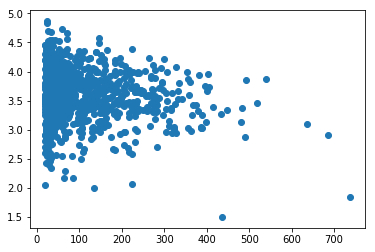

In [79]:
plt.scatter(ratem.amount,ratem.ave_rating)
plt.show()

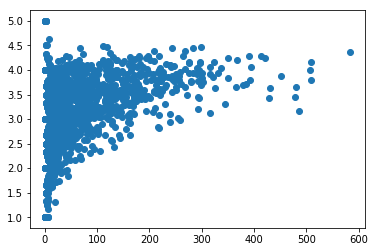

In [80]:
plt.scatter(rateu.amount,rateu.ave_rating)
plt.show()

The skewness suggests that the missing is not random.

# Q3.

We can group users and items using the missing patterns in dataset. It can provide a more informative grouping in group specific recommendation.

In [81]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(ratem[["amount"]], ratem.ave_rating)
print('Coefficients: \n', regr.coef_)
regr.fit(rateu[["amount"]], rateu.ave_rating)
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [-0.00060785]
Coefficients: 
 [0.00417805]


Users who watch more tend to give lower rates. Items watched my more users have higher rating. These features (i.e. 2 of the missing patterns) could be inluencial if applied in recommendation.